# 2.1 Document Clustering on Key Words

## 2.1.1 Data Import

In [1]:
import pandas as pd

# Load cleaned dataset in
metadata_dataset = pd.read_csv("../Processed_Dataset/cleaned_dataset.csv", keep_default_na=False, na_values=[""])
metadata_dataset

,Unnamed: 0,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,transcript
0,0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,Good morning. How are you?(Laughter)It's been ...
1,1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,"Thank you so much, Chris. And it's truly a gre..."
2,2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292,"(Music: ""The Sound of Silence,"" Simon & Garfun..."
3,3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550,If you're here today — and I'm very happy that...
4,4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869,"About 10 years ago, I took on the task to teac..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,2407,17,"Between 2008 and 2016, the United States depor...",476,TED2017,1496707200,4,Duarte Geraldino,Duarte Geraldino: What we're missing in the de...,1,1505851216,"[{'id': 3, 'name': 'Courageous', 'count': 24},...","[{'id': 2596, 'hero': 'https://pe.tedcdn.com/i...",Journalist,"['TED Residency', 'United States', 'community'...",What we're missing in the debate about immigra...,https://www.ted.com/talks/duarte_geraldino_wha...,450430,"So, Ma was trying to explain something to me a..."
2336,2408,6,How can you study Mars without a spaceship? He...,290,TED2017,1492992000,3,Armando Azua-Bustos,Armando Azua-Bustos: The most Martian place on...,1,1505919737,"[{'id': 22, 'name': 'Fascinating', 'count': 32...","[{'id': 2491, 'hero': 'https://pe.tedcdn.com/i...",Astrobiologist,"['Mars', 'South America', 'TED Fellows', 'astr...",The most Martian place on Earth,https://www.ted.com/talks/armando_azua_bustos_...,417470,This is a picture of a sunset on Mars taken by...
2337,2409,10,Science fiction visions of the future show us ...,651,TED2017,1492992000,1,Radhika Nagpal,Radhika Nagpal: What intelligent machines can ...,1,1506006095,"[{'id': 1, 'name': 'Beautiful', 'count': 14}, ...","[{'id': 2346, 'hero': 'https://pe.tedcdn.com/i...",Robotics engineer,"['AI', 'ants', 'fish', 'future', 'innovation',...",What intelligent machines can learn from a sch...,https://www.ted.com/talks/radhika_nagpal_what

## 2.1.2 Data Pre-Processing

In [2]:
import gensim
import nltk
import re

stop_list = nltk.corpus.stopwords.words("english")
stemmer = nltk.stem.porter.PorterStemmer()

# Converts text files into a corpus
corpus = nltk.corpus.PlaintextCorpusReader("./Transcripts/", ".+\.txt")

In [3]:
# Pre-processing Data 
fids = corpus.fileids()
docs1 = [corpus.words(f) for f in fids] 
docs2 = [[w.lower() for w in doc] for doc in docs1]
docs3 = [[w for w in doc if re.search('^[a-z]+$', w)] for doc in docs2]
docs4 = [[w for w in doc if w not in stop_list] for doc in docs3]
docs5 = [[stemmer.stem(w) for w in doc] for doc in docs4]


In [4]:
dictionary = gensim.corpora.Dictionary(docs5)

# Convert the list of documents into sparse vectors
vecs1 = [dictionary.doc2bow(doc) for doc in docs5]
tfidf = gensim.models.TfidfModel(vecs1)
vecs2 = [tfidf[vec] for vec in vecs1]
print(dictionary)

Dictionary(35153 unique tokens: ['abil', 'abstract', 'academ', 'accord', 'achiev']...)


## 2.1.3 Data Clustering

### 2.1.3.1 Identifying Optimal K 

### Data Processing

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from nltk.stem.porter import PorterStemmer

import nltk
import string

import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('fivethirtyeight')


In [6]:
data = pd.read_csv("../Processed_Dataset/cleaned_dataset.csv", keep_default_na=False, na_values=[""])['transcript']
stemmer = nltk.stem.porter.PorterStemmer()

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('^[a-z]+$', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

# This methods pre-processes the corpus by 1. lowercase 2. Remove Punctuations 3. Remove stopwords 4. Tokenize and Stem
tf_idf_vectorizor = TfidfVectorizer(tokenizer=tokenize_and_stem, stop_words='english')

#learn the vocabularies and return a document-term matrix.
tf_idf = tf_idf_vectorizor.fit_transform(data) 

#normalise, unsure if we need this
tf_idf_norm = normalize(tf_idf) 

tf_idf_array = tf_idf_norm.toarray()


/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop

### Identifying Optimal K (First Method)
Adapted from: https://towardsdatascience.com/k-means-clustering-8e1e64c1561c

In [7]:
# similar to NLTK's token2id function. Dictionary of feature:id
token_id = tf_idf_vectorizor.vocabulary_
token_id = {k: v for k, v in sorted(token_id.items(), key=lambda token_id: token_id[1])}
print(token_id)

{'aa': 0, 'aaa': 1, 'aaaa': 2, 'aaaaa': 3, 'aaaaaaaah': 4, 'aaaaaaah': 5, 'aaaaaah': 6, 'aaaab': 7, 'aaaah': 8, 'aaaahhh': 9, 'aaah': 10, 'aag': 11, 'aah': 12, 'aak': 13, 'aakash': 14, 'aaleh': 15, 'aalto': 16, 'aargh': 17, 'aarhu': 18, 'aaron': 19, 'aaronson': 20, 'aarp': 21, 'aat': 22, 'aatcagggaccc': 23, 'aaudienc': 24, 'ab': 25, 'aba': 26, 'ababa': 27, 'abacazanian': 28, 'abacha': 29, 'abaci': 30, 'aback': 31, 'abaco': 32, 'abacu': 33, 'abacus': 34, 'abalon': 35, 'abandon': 36, 'abani': 37, 'abarth': 38, 'abashedli': 39, 'abat': 40, 'abattoir': 41, 'abaya': 42, 'abba': 43, 'abbeel': 44, 'abbey': 45, 'abbi': 46, 'abbott': 47, 'abbottabad': 48, 'abbrevi': 49, 'abc': 50, 'abdellahi': 51, 'abdelrahman': 52, 'abdic': 53, 'abdirizak': 54, 'abdomen': 55, 'abdomin': 56, 'abduct': 57, 'abducte': 58, 'abdul': 59, 'abdullah': 60, 'abdur': 61, 'abdurrahman': 62, 'abe': 63, 'abecedarian': 64, 'abel': 65, 'abend': 66, 'aberdeen': 67, 'abernathey': 68, 'abernathi': 69, 'aberr': 70, 'abet': 71, 'a

In [8]:
#Checking of the words are stemmed
keyvalue = list(token_id.keys()) 

count = 0 
for x in tf_idf_array[1]:
    if x > 0:
        print("id: ",keyvalue[count]," | score: ",x)
    count+=1
    

id:  accomplish  | score:  0.02631768320623527
id:  acquir  | score:  0.030241993936591702
id:  activ  | score:  0.03334800313688516
id:  ad  | score:  0.04101741073530886
id:  add  | score:  0.019713821150635146
id:  address  | score:  0.02107165441593018
id:  advic  | score:  0.02759342529880233
id:  africa  | score:  0.019321272526849037
id:  ago  | score:  0.010879631405070887
id:  air  | score:  0.03658874445316511
id:  airplan  | score:  0.02700928016910337
id:  airport  | score:  0.028937022587388155
id:  al  | score:  0.1131981365360237
id:  alreadi  | score:  0.04127450685334913
id:  america  | score:  0.03491391448893828
id:  american  | score:  0.016243978335117242
id:  anderson  | score:  0.025643723577802015
id:  announc  | score:  0.024663241423073294
id:  annual  | score:  0.029477557030367786
id:  anoth  | score:  0.010244965685182707
id:  anybodi  | score:  0.019524077410199906
id:  app  | score:  0.02796950204464218
id:  applaus  | score:  0.04312006443919996
id:  app

id:  lebanon  | score:  0.03971084940204414
id:  left  | score:  0.012954565276259713
id:  legal  | score:  0.024545134698045437
id:  length  | score:  0.027065497238809435
id:  leno  | score:  0.05508792749557598
id:  lessig  | score:  0.05231846480955685
id:  let  | score:  0.00937451506567784
id:  letter  | score:  0.022560682233236498
id:  letterman  | score:  0.05231846480955685
id:  level  | score:  0.014989020389779504
id:  liabil  | score:  0.040470557796198674
id:  life  | score:  0.019231728654758015
id:  lifelong  | score:  0.03462607126429264
id:  light  | score:  0.015086043830984329
id:  like  | score:  0.049432556395356785
id:  limb  | score:  0.03208816754718707
id:  link  | score:  0.022416272300022046
id:  listen  | score:  0.01719917814580811
id:  littl  | score:  0.018241943668148797
id:  live  | score:  0.008979635582583786
id:  logic  | score:  0.025552651089744628
id:  long  | score:  0.03361175126297542
id:  longer  | score:  0.01658823838270695
id:  look  | sco

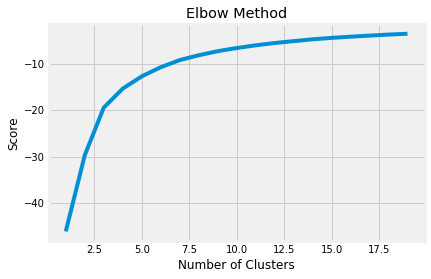

In [9]:
#tbh idk wtf these does
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)

number_clusters = range(1, 20)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

### Identifying Optimal K (Second Method)
Adapted from: https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

In [ ]:
Sum_of_squared_distances = []
K = range(1,250)
for k in K:
    print("running: ", k)
    km = KMeans(n_clusters=k)
    km = km.fit(tf_idf_array)
    Sum_of_squared_distances.append(km.inertia_)

running:  1
running:  2
running:  3
running:  4
running:  5
running:  6
running:  7
running:  8
running:  9
running:  10
running:  11
running:  12
running:  13
running:  14
running:  15
running:  16
running:  17
running:  18
running:  19
running:  20
running:  21
running:  22
running:  23
running:  24
running:  25
running:  26
running:  27
running:  28
running:  29
running:  30
running:  31
running:  32
running:  33
running:  34
running:  35
running:  36
running:  37
running:  38
running:  39
running:  40
running:  41
running:  42
running:  43
running:  44
running:  45
running:  46
running:  47
running:  48
running:  49
running:  50
running:  51
running:  52
running:  53
running:  54
running:  55
running:  56
running:  57
running:  58
running:  59
running:  60
running:  61
running:  62
running:  63


In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
## Showing 100 Clusters 
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## 2. K-Means Clustering

In [ ]:
import k_means

num_tokens = len(dictionary.token2id)
clusters = k_means.k_means(vecs2, num_tokens, 10)


# Document Retrieval

In [ ]:
from gensim import similarities

# DOCUMENT RETRIEVAL????
similarity_index = similarities.SparseMatrixSimilarity(vecs1, len(dictionary))

test_vector = vecs1[100]
sims = similarity_index[test_vector]
sorted_sims = sorted(enumerate(sims), key = lambda item: -item[1])

print(list(enumerate(sorted_sims)))

## Archieved - Ignore the Below

In [ ]:
import numpy as np # linear algebra
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
import string
import kmeans


import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline
plt.style.use('fivethirtyeight')


metadata_dataset = pd.read_csv("../Processed_Dataset/cleaned_dataset.csv", keep_default_na=False, na_values=[""])

data = metadata_dataset['transcript']

tfidf = TfidfVectorizer(
    max_features = 8000,
    stop_words = 'english',
     

tfidf.fit(data)
text = tfidf.transform(data)

print(type(tfid))

# def find_optimal_clusters(data, max_k):
#     iters = range(2, max_k+1, 2)
    
#     sse = []
#     for k in iters:
#         sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
#         print('Fit {} clusters'.format(k))
        
#     f, ax = plt.subplots(1, 1)
#     ax.plot(iters, sse, marker='o')
#     ax.set_xlabel('Cluster Centers')
#     ax.set_xticks(iters)
#     ax.set_xticklabels(iters)
#     ax.set_ylabel('SSE')
#     ax.set_title('SSE by Cluster Center Plot')
    
# find_optimal_clusters(text, 150)

#vecs1 = [dictionary.doc2bow(doc) for doc in docs5]

#tf_idf = vecs1.fit_transform(data) 

In [ ]:
print(type(data))

In [ ]:
from sklearn.datasets import load_breast_cancer
breast = load_breast_cancer()
breast_data = breast.data

print(breast_data)